# 1. Predicting Gender of Brazilian Names Using Deep Learning


## 1.1 Necessary libraries

In [ ]:
import pandas as pd                       
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

## 1.2 Download the dataset

In [ ]:
"""
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)
"""
df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


In [ ]:
# Ratio = 1.0
#df = df[df['ratio'] == 1.0].copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90158 entries, 0 to 100786
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   alternative_names  61607 non-null  object 
 1   classification     90158 non-null  object 
 2   first_name         90158 non-null  object 
 3   frequency_female   49855 non-null  float64
 4   frequency_male     40303 non-null  float64
 5   frequency_total    90158 non-null  int64  
 6   frequency_group    90158 non-null  int64  
 7   group_name         90158 non-null  object 
 8   ratio              90158 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


### 1.2.1 Preparing the data 

In [ ]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

In [ ]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [ ]:
#word encoding
maxlen = 20                                               # max lenght of a name
'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)
''' The dictionary maps each letter of vocabulary to a number '''
char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [ ]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

## 1.4 Split the data into test and train

In [ ]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [ ]:
x_train.shape

(57700, 20, 28)

In [ ]:
y_train.shape

(57700,)

In [ ]:
# Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_f1_score', mode="max", patience=5)]

In [ ]:
# Results
def results(scores):
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("F1 score: %.2f%%" % (scores[2]*100)) 

## 1.5 Building the CNN Model

In [ ]:
"""
checkpoint_filepath = './models/cnn_softmax'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='f1_score',
    mode='max',
    save_best_only=True)
"""
CNNmodel = keras.Sequential()
CNNmodel.add(Conv1D(256, 3, activation='relu', kernel_initializer='he_uniform', input_shape=(20, 28)))
CNNmodel.add(Conv1D(256, 3, activation='relu'))
CNNmodel.add(Flatten())
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

CNNmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1_score])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
CNNscores = CNNmodel.evaluate(x_test, y_test) 
results(CNNscores)

Epoch 1/100
252/252 [==============================] - 68s 265ms/step - loss: 0.2719 - accuracy: 0.8812 - f1_score: 0.8645 - val_loss: 0.1785 - val_accuracy: 0.9309 - val_f1_score: 0.9212
Epoch 2/100
252/252 [==============================] - 66s 263ms/step - loss: 0.1641 - accuracy: 0.9367 - f1_score: 0.9299 - val_loss: 0.1525 - val_accuracy: 0.9418 - val_f1_score: 0.9353
Epoch 3/100
252/252 [==============================] - 65s 259ms/step - loss: 0.1437 - accuracy: 0.9453 - f1_score: 0.9393 - val_loss: 0.1434 - val_accuracy: 0.9451 - val_f1_score: 0.9393
Epoch 4/100
252/252 [==============================] - 65s 260ms/step - loss: 0.1313 - accuracy: 0.9503 - f1_score: 0.9448 - val_loss: 0.1599 - val_accuracy: 0.9387 - val_f1_score: 0.9343
Epoch 5/100
252/252 [==============================] - 65s 257ms/step - loss: 0.1209 - accuracy: 0.9552 - f1_score: 0.9502 - val_loss: 0.1285 - val_accuracy: 0.9509 - val_f1_score: 0.9455
Epoch 6/100
252/252 [==============================] - 65s 2

## 1.6 Building the RNN Model

In [ ]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1))) 
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

RNNhistory=RNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
RNNscores = RNNmodel.evaluate(x_test, y_test) 
results(RNNscores)

Epoch 1/100
252/252 [==============================] - 5s 15ms/step - loss: 0.3099 - accuracy: 0.8601 - f1_score: 0.8406 - val_loss: 0.2265 - val_accuracy: 0.9103 - val_f1_score: 0.9010
Epoch 2/100
252/252 [==============================] - 3s 13ms/step - loss: 0.2148 - accuracy: 0.9146 - f1_score: 0.9054 - val_loss: 0.2054 - val_accuracy: 0.9212 - val_f1_score: 0.9129
Epoch 3/100
252/252 [==============================] - 3s 12ms/step - loss: 0.1953 - accuracy: 0.9231 - f1_score: 0.9148 - val_loss: 0.1957 - val_accuracy: 0.9270 - val_f1_score: 0.9185
Epoch 4/100
252/252 [==============================] - 3s 12ms/step - loss: 0.1836 - accuracy: 0.9270 - f1_score: 0.9190 - val_loss: 0.1827 - val_accuracy: 0.9289 - val_f1_score: 0.9209
Epoch 5/100
252/252 [==============================] - 3s 12ms/step - loss: 0.1766 - accuracy: 0.9311 - f1_score: 0.9238 - val_loss: 0.1802 - val_accuracy: 0.9295 - val_f1_score: 0.9221
Epoch 6/100
252/252 [==============================] - 3s 11ms/step - 

## 1.7 Building the GRU Model

In [ ]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

GRUhistory=GRUmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
GRUscores = GRUmodel.evaluate(x_test, y_test)
results(GRUscores)

Epoch 1/100
252/252 [==============================] - 9s 26ms/step - loss: 0.2595 - accuracy: 0.8874 - f1_score: 0.8703 - val_loss: 0.1921 - val_accuracy: 0.9261 - val_f1_score: 0.9179
Epoch 2/100
252/252 [==============================] - 6s 25ms/step - loss: 0.1800 - accuracy: 0.9307 - f1_score: 0.9232 - val_loss: 0.1732 - val_accuracy: 0.9342 - val_f1_score: 0.9273
Epoch 3/100
252/252 [==============================] - 6s 26ms/step - loss: 0.1598 - accuracy: 0.9386 - f1_score: 0.9321 - val_loss: 0.1581 - val_accuracy: 0.9410 - val_f1_score: 0.9347
Epoch 4/100
252/252 [==============================] - 6s 24ms/step - loss: 0.1443 - accuracy: 0.9456 - f1_score: 0.9397 - val_loss: 0.1523 - val_accuracy: 0.9417 - val_f1_score: 0.9339
Epoch 5/100
252/252 [==============================] - 6s 25ms/step - loss: 0.1341 - accuracy: 0.9492 - f1_score: 0.9438 - val_loss: 0.1459 - val_accuracy: 0.9437 - val_f1_score: 0.9373
Epoch 6/100
252/252 [==============================] - 6s 25ms/step - 

## 1.8 Building the DNN Model

In [ ]:
DNNmodel = keras.Sequential()                                   # Sequential model
n_inputs = 28                                                   # nº of states  
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')      # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
DNNmodel = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

DNNhistory = DNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
DNNscores = DNNmodel.evaluate(x_test, y_test) 
results(DNNscores)

Epoch 1/100
252/252 [==============================] - 9s 33ms/step - loss: 0.4840 - accuracy: 0.7910 - f1_score: 0.7365 - val_loss: 0.3194 - val_accuracy: 0.8615 - val_f1_score: 0.8422
Epoch 2/100
252/252 [==============================] - 8s 32ms/step - loss: 0.3277 - accuracy: 0.8556 - f1_score: 0.8349 - val_loss: 0.3332 - val_accuracy: 0.8536 - val_f1_score: 0.8455
Epoch 3/100
252/252 [==============================] - 8s 32ms/step - loss: 0.3251 - accuracy: 0.8563 - f1_score: 0.8355 - val_loss: 0.3186 - val_accuracy: 0.8604 - val_f1_score: 0.8322
Epoch 4/100
252/252 [==============================] - 8s 32ms/step - loss: 0.3223 - accuracy: 0.8594 - f1_score: 0.8393 - val_loss: 0.3100 - val_accuracy: 0.8659 - val_f1_score: 0.8467
Epoch 5/100
252/252 [==============================] - 8s 32ms/step - loss: 0.3176 - accuracy: 0.8615 - f1_score: 0.8421 - val_loss: 0.3120 - val_accuracy: 0.8634 - val_f1_score: 0.8417
Epoch 6/100
252/252 [==============================] - 8s 32ms/step - 

## 1.9 Building the BiLSTM Model

In [ ]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

LSTMhistory = LSTMmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
LSTMscores = LSTMmodel.evaluate(x_test, y_test) 
results(LSTMscores)

## 1.10 Figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

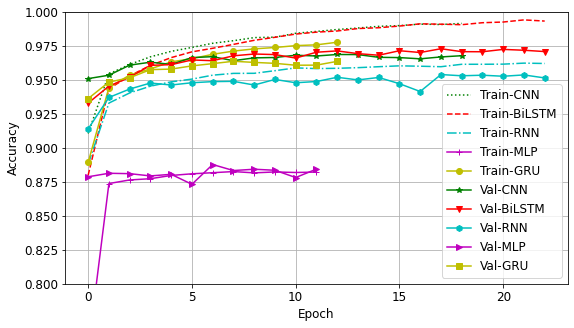

In [ ]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
#plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='lower right')

plt.gcf().savefig('accR1.eps', format='eps', dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

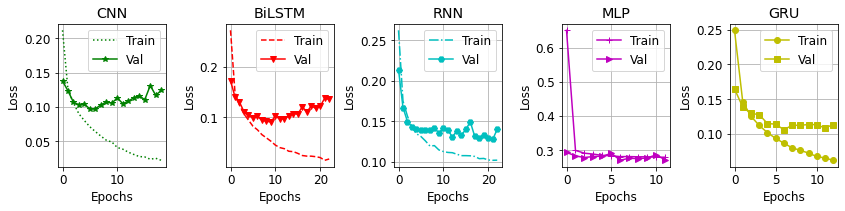

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.tight_layout(pad=2.0)             #space between plots
#fig.set_size_inches(9,6)
plt.rcParams.update({'font.size': 12}) 

axes[0].plot(CNNhistory.history['loss'], 'g:')
axes[1].plot(LSTMhistory.history['loss'], 'r--')
axes[2].plot(RNNhistory.history['loss'], 'c-.')
axes[3].plot(DNNhistory.history['loss'], 'm-+')
axes[4].plot(GRUhistory.history['loss'], 'y-o')


axes[0].plot(CNNhistory.history['val_loss'], 'g-*')
axes[1].plot(LSTMhistory.history['val_loss'], 'r-v')
axes[2].plot(RNNhistory.history['val_loss'], 'c-H')
axes[3].plot(DNNhistory.history['val_loss'], 'm->')
axes[4].plot(GRUhistory.history['val_loss'], 'y-s')


axes[0].set_title('CNN')
axes[1].set_title('BiLSTM')
axes[2].set_title('RNN')
axes[3].set_title('MLP')
axes[4].set_title('GRU')

axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[3].grid(True)
axes[4].grid(True)

axes[0].legend(['Train', 'Val'], loc='upper right')
axes[1].legend(['Train', 'Val'], loc='upper right')
axes[2].legend(['Train', 'Val'], loc='upper right')
axes[3].legend(['Train', 'Val'], loc='upper right')
axes[4].legend(['Train', 'Val'], loc='upper right')

for i in range(0,5):
  axes[i].set_xlabel('Epochs')
  axes[i].set_ylabel('Loss')


plt.gcf().savefig('lossR1.eps', format='eps', dpi=600)

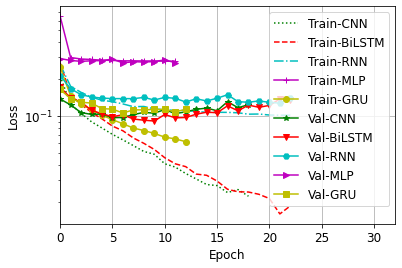

In [ ]:
plt.figure(2)
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')
plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')
plt.grid('True')
plt.xlim(0,32)
plt.yscale('log')

<Figure size 432x288 with 0 Axes>

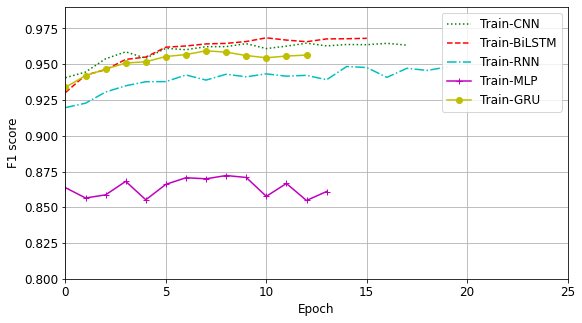

In [ ]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['val_f1_score'], 'g:')
plt.plot(LSTMhistory.history['val_f1_score'], 'r--')
plt.plot(RNNhistory.history['val_f1_score'], 'c-.')
plt.plot(DNNhistory.history['val_f1_score'], 'm-+')
plt.plot(GRUhistory.history['val_f1_score'], 'y-o')
plt.grid('True')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')

## 1.11 Statistics

In [ ]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

In [ ]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_predLSTM))
print(recall_score(y_test, y_predLSTM))

print(precision_score(y_test, y_predRNN))
print(recall_score(y_test, y_predRNN))

print(precision_score(y_test, y_predCNN))
print(recall_score(y_test, y_predCNN))

print(precision_score(y_test, y_predGRU))
print(recall_score(y_test, y_predGRU))

print(precision_score(y_test, y_predDNN))
print(recall_score(y_test, y_predDNN))

0.9720130522088354
0.959727385377943
0.9490239960213851
0.9458488228004956
0.972544080604534
0.9568773234200744
0.9574468085106383
0.9646840148698885
0.8986691263671103
0.8451053283767038


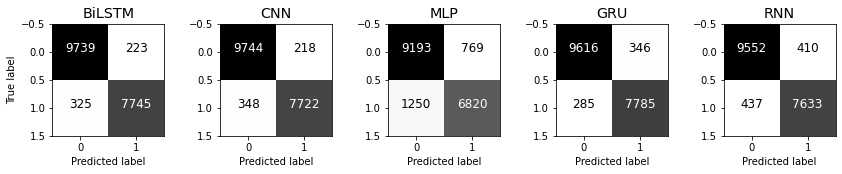

In [ ]:
# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
%matplotlib inline
import itertools

cm1 = confusion_matrix(y_true=y_test, y_pred=y_predLSTM)
cm2 = confusion_matrix(y_true=y_test, y_pred=y_predCNN)
cm3 = confusion_matrix(y_true=y_test, y_pred=y_predDNN)
cm4 = confusion_matrix(y_true=y_test, y_pred=y_predGRU)
cm5 = confusion_matrix(y_true=y_test, y_pred=y_predRNN)


fig, axes = plt.subplots(1, 5, figsize=(12, 4))
fig.tight_layout(pad=2.5)             #space between plots
#fig.set_size_inches(9,6)
plt.rcParams.update({'font.size': 12}) 
cmap=plt.cm.Greys

axes[0].imshow(cm1, interpolation='nearest', cmap=cmap)
axes[0].set_title('BiLSTM')
#axes[0].colorbar()
thresh = cm1.max() / 2.
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
  axes[0].text(j, i, cm1[i, j],
  horizontalalignment="center",
  color="white" if cm1[i, j] > thresh else "black")
  axes[0].set_ylabel('True label')
  axes[0].set_xlabel('Predicted label')

axes[1].imshow(cm2, interpolation='nearest', cmap=cmap)
axes[1].set_title('CNN')
thresh = cm2.max() / 2.
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
  axes[1].text(j, i, cm2[i, j],
  horizontalalignment="center",
  color="white" if cm2[i, j] > thresh else "black")
  #axes[1].set_ylabel('True label')
  axes[1].set_xlabel('Predicted label')

axes[2].imshow(cm3, interpolation='nearest', cmap=cmap)
axes[2].set_title('MLP')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
  axes[2].text(j, i, cm3[i, j],
  horizontalalignment="center",
  color="white" if cm3[i, j] > thresh else "black")
  #axes[2].set_ylabel('True label')
  axes[2].set_xlabel('Predicted label')

axes[3].imshow(cm4, interpolation='nearest', cmap=cmap)
axes[3].set_title('GRU')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm4.shape[0]), range(cm4.shape[1])):
  axes[3].text(j, i, cm4[i, j],
  horizontalalignment="center",
  color="white" if cm4[i, j] > thresh else "black")
  #axes[3].set_ylabel('True label')
  axes[3].set_xlabel('Predicted label')


axes[4].imshow(cm5, interpolation='nearest', cmap=cmap)
axes[4].set_title('RNN')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm5.shape[0]), range(cm5.shape[1])):
  axes[4].text(j, i, cm5[i, j],
  horizontalalignment="center",
  color="white" if cm5[i, j] > thresh else "black")
  #axes[4].set_ylabel('True label')
  axes[4].set_xlabel('Predicted label')


#plt.show(block=False)

plt.gcf().savefig('cmR1.pdf', format='pdf', dpi=1200)

## 1.12 Testing 

In [ ]:
testename = prepare_encod_names({"cibely"})   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

F
